# Benchmark: Manns Lab Patient Dataset

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

import data_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s define the paths.

In [8]:
MAIN_DIR = "../../data/manns_lab/MAIN/"
PILOT_DIR = "../../data/manns_lab/PILOT/"

Let"s load the data.

In [9]:
adata = sup.load_data(MAIN_DIR, PILOT_DIR, do_batch_correction=True, integrate=True)

preprocess input: (4566, 2703)
sc.pp.filter_genes: (4566, 2703)
sc.pp.filter_cells: (4566, 2703)
filter: (4566, 2018)
preprocess input: (454, 3306)
sc.pp.filter_genes: (454, 3305)
sc.pp.filter_cells: (454, 3305)
filter: (454, 2963)


/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/notebooks/manns_inhouse/data_support.py:312: RuntimeWarning: Mean of empty slice
  mean_protein_per_plate = np.nanmean(x, axis=0)


transfering 447 cells and 1783 proteins during reshape.

main intensity coverage:     69.66%
pilot intensity coverage:    7.47%
combined intensity coverage: 71.28%


## PROTVI

### Training

Let's now train the model.

In [10]:
adata.X = adata.layers["main"].copy()
adata.X[np.isnan(adata.X)] = 0

In [11]:
PROTVI.setup_anndata(adata, batch_key="Plate")#, continuous_covariate_keys=["log Qalb"])

model = PROTVI(adata, log_variational=False, decoder_type="conjunction")
#model.view_anndata_setup()

Let's train the model.

In [12]:
model.train(max_epochs=1500, plan_kwargs={"mechanism_weight": 1}, check_val_every_n_epoch=1) #, plan_kwargs={"min_kl_weight": 8, "max_kl_weight": 8})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1500/1500: 100%|██████████| 1500/1500 [39:38<00:00,  1.03it/s, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.08e+3]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [39:38<00:00,  1.59s/it, v_num=1, train_loss_step=1.15e+3, train_loss_epoch=1.08e+3]


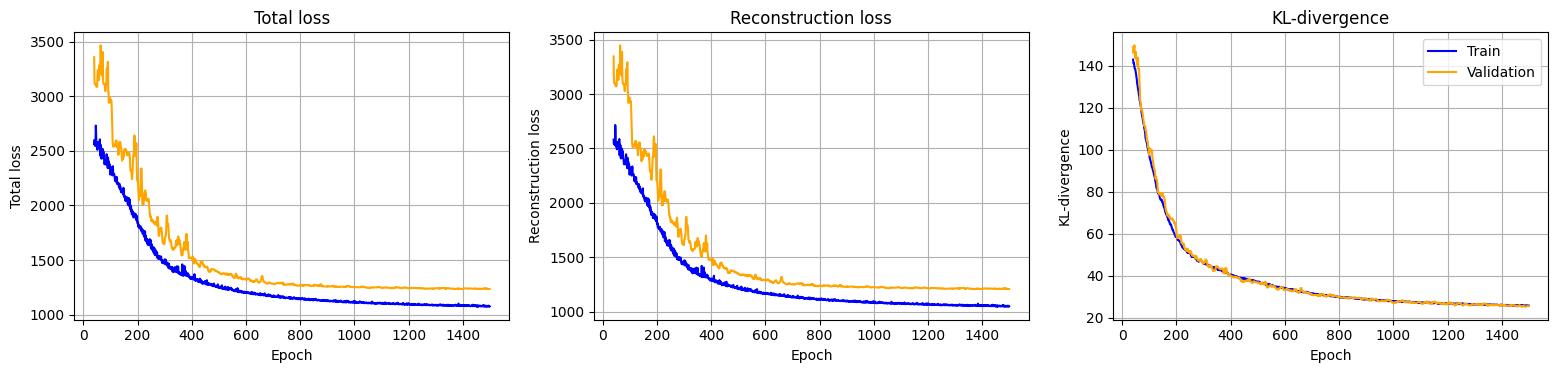

In [13]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

### Evaluation on training set (MAIN)

In [14]:
x_est, p_est = model.impute()

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

Let's compute compute some common performance metrics to compare with other models later.

In [15]:
common_metrics = sup.compute_common_metrics(x_main, x_pilot, x_est)
sup.save_dict_to_results(common_metrics, "protvi conjunction.pkl")

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

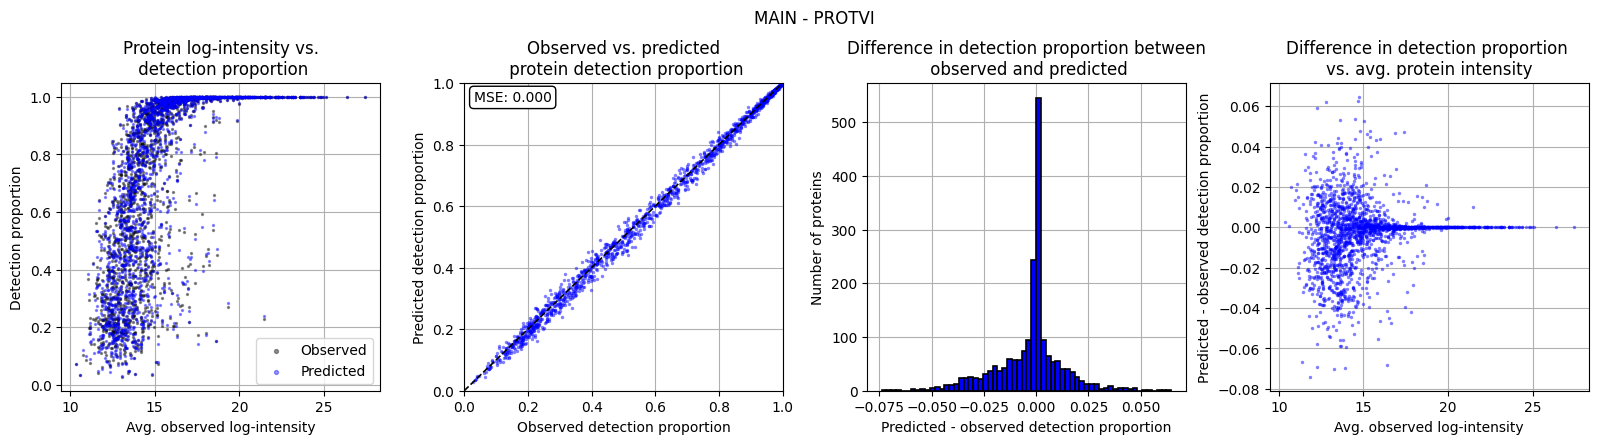

In [16]:
pl.plot_protein_detection_proportion_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

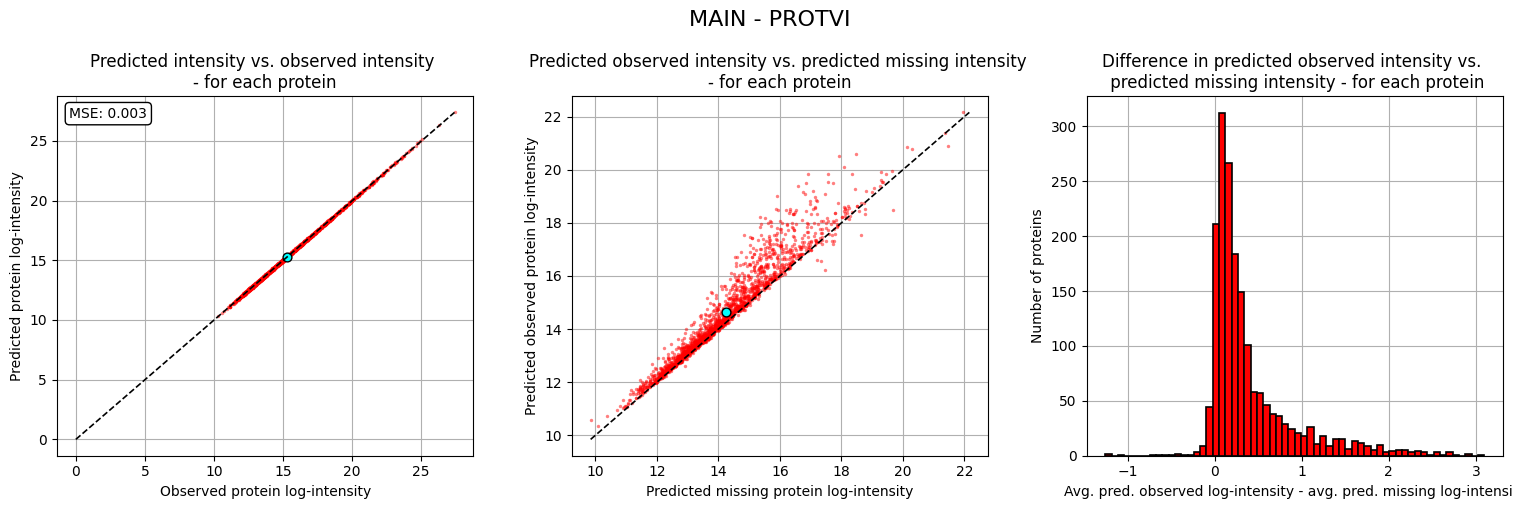

In [17]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

Let's look at the latent space.

In [18]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

2023-12-11 18:47:14.815420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 18:47:14.815467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 18:47:14.816218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 18:47:15.847222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


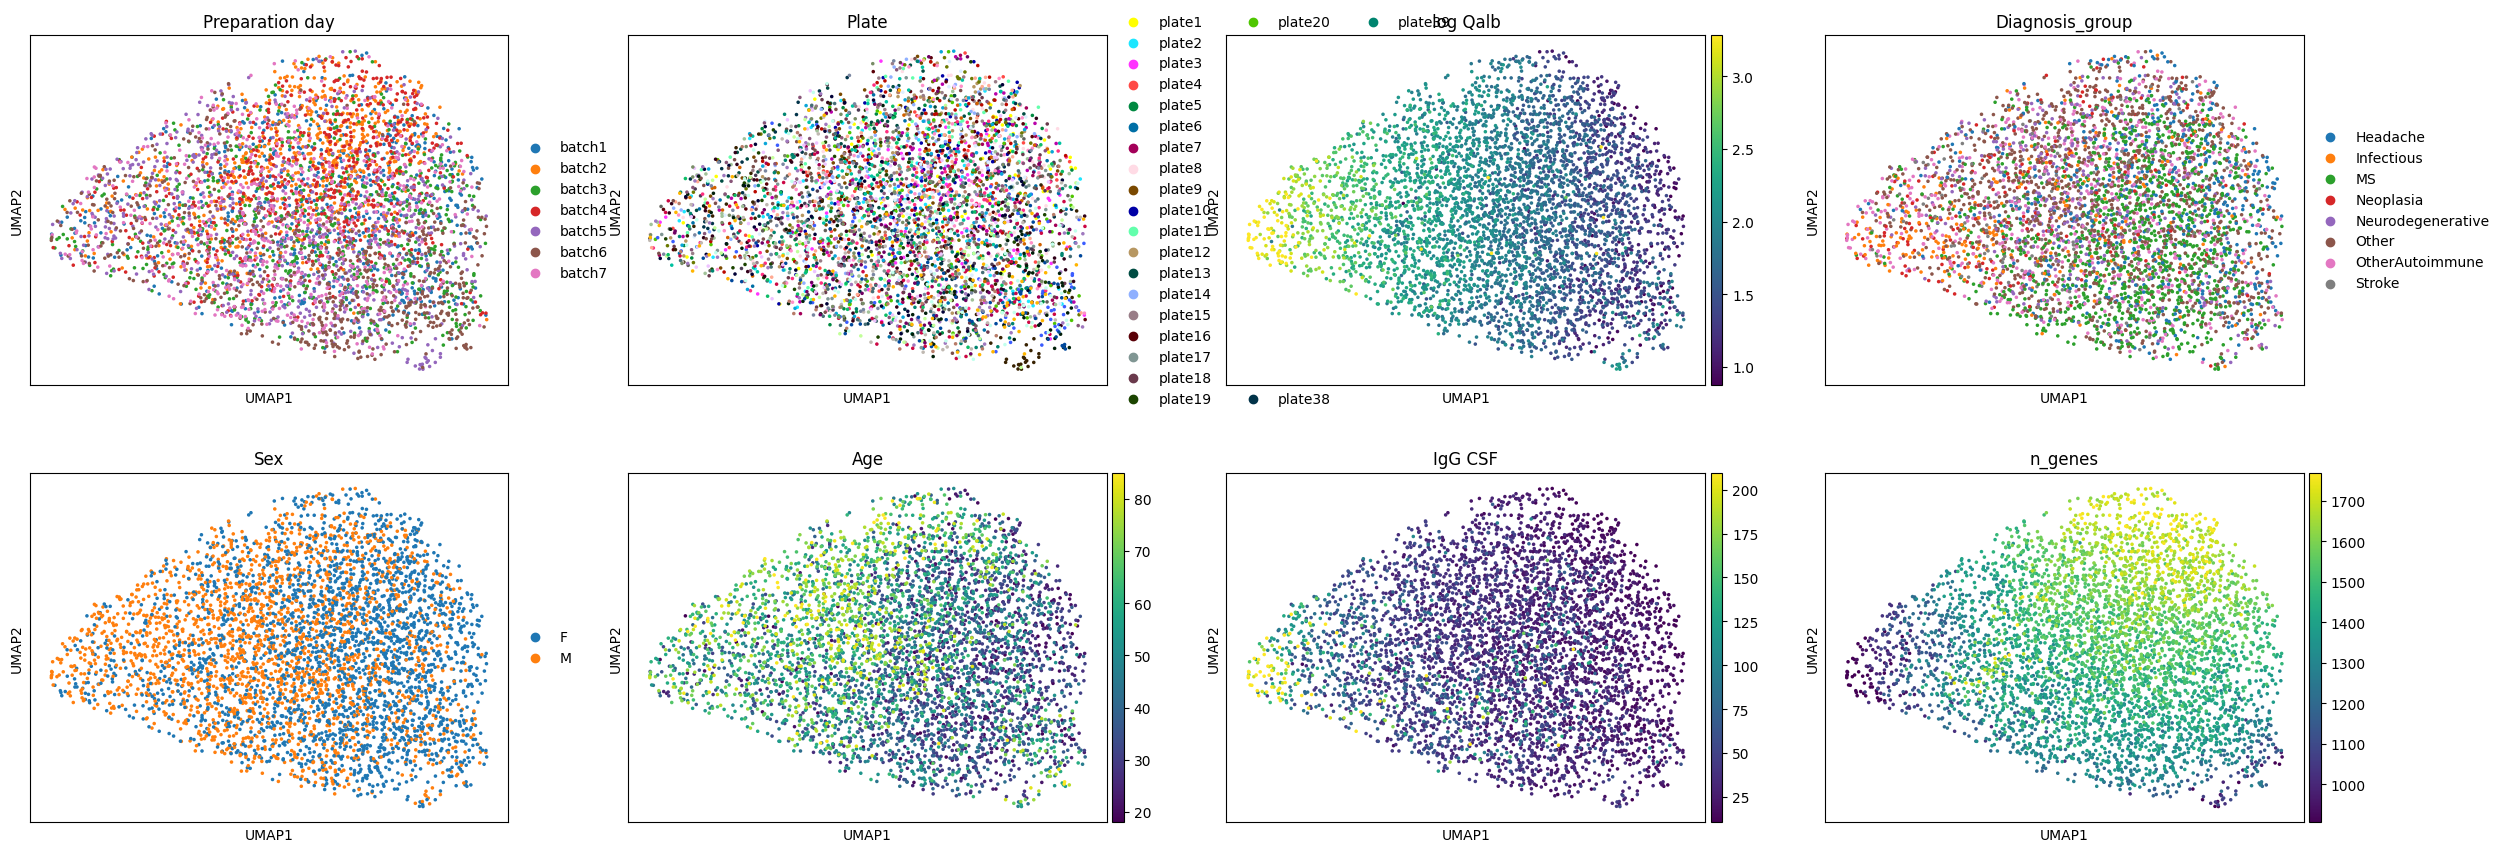

In [19]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["Preparation day", "Plate", "log Qalb", "Diagnosis_group", "Sex", "Age", "IgG CSF", "n_genes"], 
    vmin="p01", vmax="p99",
)

Let's see how much of the variance in the latent space can be explained by PCA.

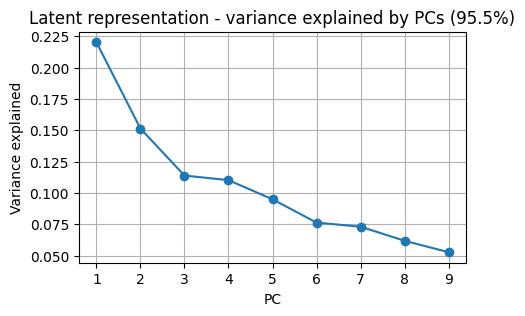

In [20]:
latent_projection, pcs, var_ratio, var = sc.tl.pca(adata.obsm["latent"], return_info=True)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.arange(1, latent_projection.shape[1]+1), var_ratio, marker="o")
ax.set_xticks(np.arange(1, latent_projection.shape[1]+1))
ax.set_xlabel("PC")
ax.set_ylabel("Variance explained")
ax.set_title(f"Latent representation - variance explained by PCs ({np.sum(var_ratio[:10])*100:.1f}%)")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the patient means and variances.

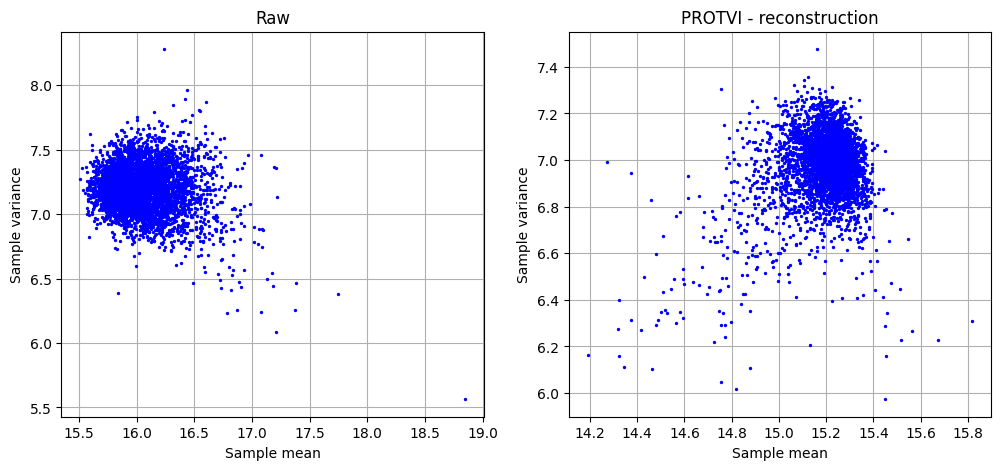

In [21]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
pl.scatter_sample_mean_and_variance(adata.layers["main"], title="Raw", ax=axes[0])
pl.scatter_sample_mean_and_variance(x_est, "PROTVI - reconstruction", ax=axes[1])

### Evaluation on validation set (PILOT)

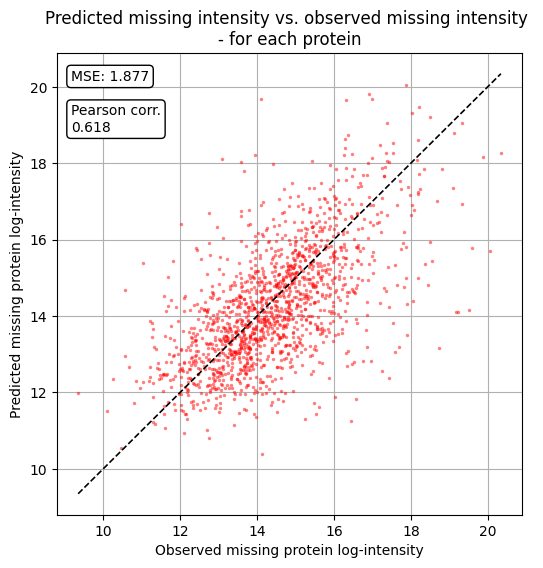

In [22]:
sup.scatter_pilot_model_by_protein(adata.layers["main"], adata.layers["pilot"], x_est)

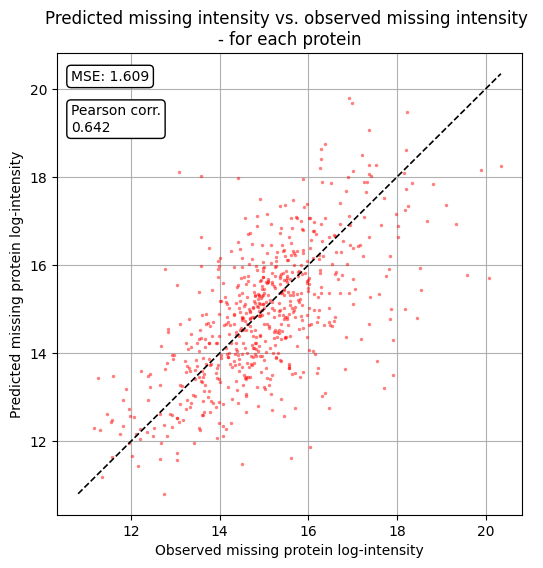

In [23]:
min_correlation = 0.4
n_min_protein_overlap = 15

corrs = metrics.compare_intensities_protein_wise(adata.layers["main"], adata.layers["pilot"], n_min_overlap=n_min_protein_overlap)
protein_idx = corrs["protein_idx"][np.array(corrs["pearson"]) > min_correlation]

sup.scatter_pilot_model_by_protein(adata.layers["main"][:, protein_idx], adata.layers["pilot"][:, protein_idx], x_est_miss[:, protein_idx])

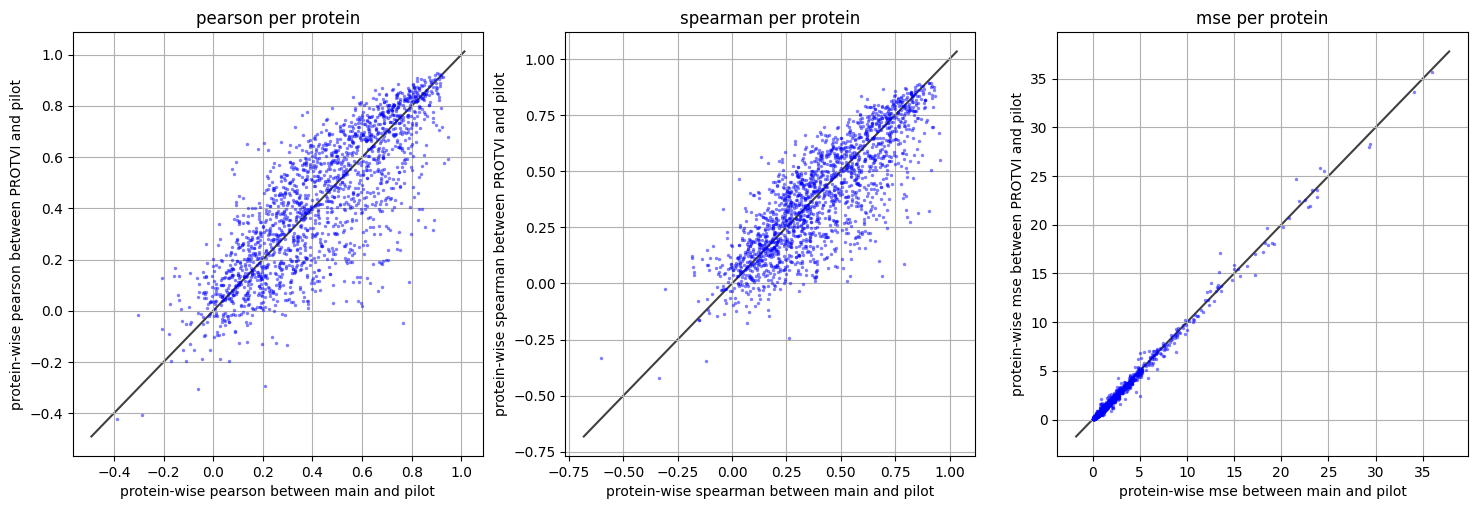

In [24]:
sup.scatter_main_pilot_model(adata.layers["main"], adata.layers["pilot"], x_est, n_min_protein_overlap=n_min_protein_overlap)

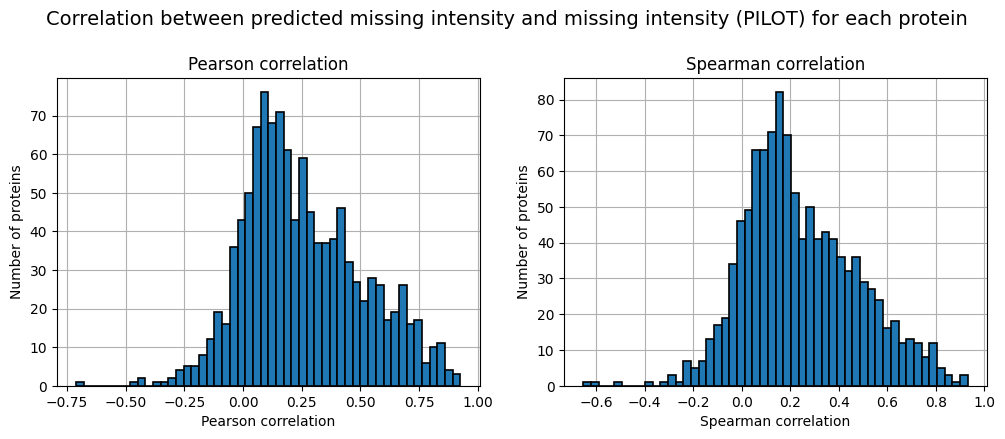

In [25]:
x_pilot = adata.layers["pilot"]

corrs = metrics.compare_intensities_protein_wise(x_est_miss, x_pilot, n_min_overlap=n_min_protein_overlap)

fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
fig.suptitle("Correlation between predicted missing intensity and missing intensity (PILOT) for each protein", fontsize=14, y=1.05)

ax = axes[0]
ax.hist(corrs["pearson"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(corrs["spearman"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

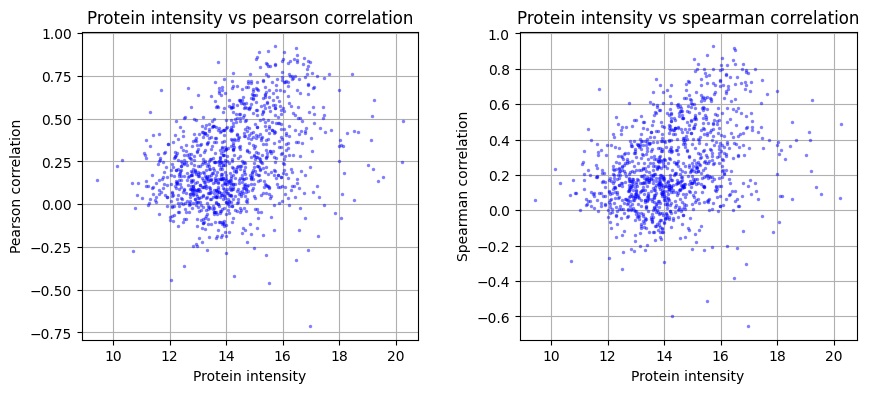

In [26]:
x_overlap = np.nanmean(x_pilot[:, corrs["protein_idx"]], axis=0)

fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.scatter(x_overlap, corrs["pearson"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs pearson correlation")
ax.set_xlabel("Protein intensity")
ax.set_ylabel("Pearson correlation")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(x_overlap, corrs["spearman"], color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_title("Protein intensity vs spearman correlation")
ax.set_xlabel("Protein intensity")
ax.set_ylabel("Spearman correlation")
ax.grid(True)
ax.set_axisbelow(True)

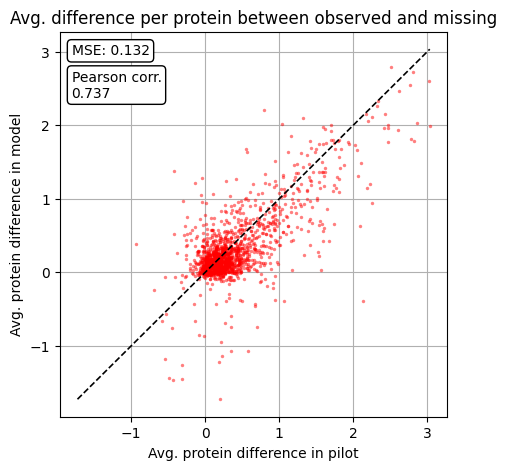

In [27]:
sup.scatter_difference_observed_and_missing_by_protein(x_pilot, x_main, x_est)